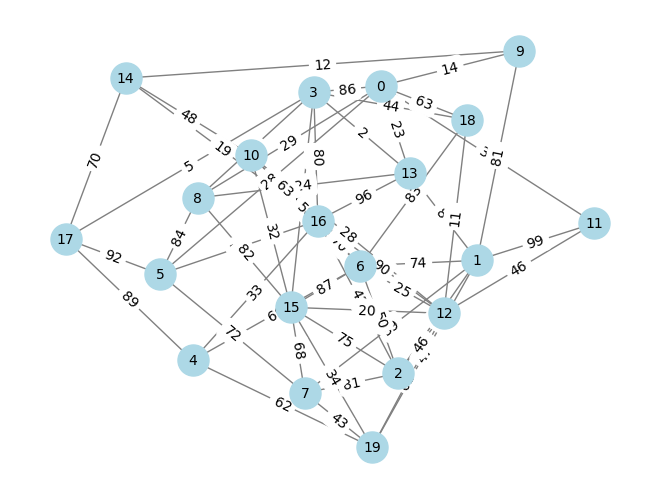

|      | timestamp                  |   source |   destination | path                      | status      |   signal_strength |
|-----:|:---------------------------|---------:|--------------:|:--------------------------|:------------|------------------:|
|    0 | 2025-01-26T14:47:39.024990 |        4 |             1 | [4, 19, 1]                | transmitted |          13.9685  |
|    1 | 2025-01-26T14:47:39.025329 |       11 |             3 | [11, 0, 13, 3]            | transmitted |          21.9069  |
|    2 | 2025-01-26T14:47:39.025579 |        5 |            18 | [5, 0, 18]                | transmitted |          11.9032  |
|    3 | 2025-01-26T14:47:39.026240 |        3 |             4 | [3, 17, 4]                | transmitted |           9.17795 |
|    4 | 2025-01-26T14:47:39.026582 |       12 |            17 | [12, 18, 3, 17]           | transmitted |          21.2595  |
|    5 | 2025-01-26T14:47:39.227227 |        4 |             8 | [4, 17, 3, 8]             | transmitted |     

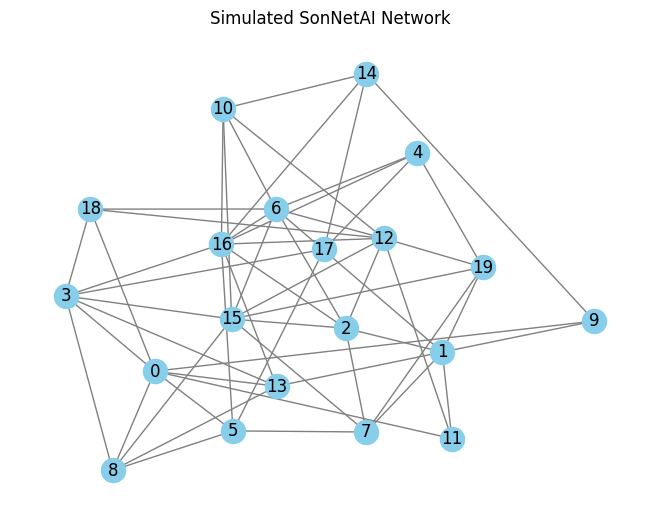

In [3]:
import networkx as nx
import numpy as np
from scipy import signal
import random
import time
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Define Simulation Parameters
NUM_NODES = 20
SIMULATION_TIME = 60  # seconds
PACKET_RATE = 5 # Packets per second
MAX_DISTANCE = 100 # meters
FAILURE_RATE = 0.001 # Probability of node failure per second

# Initialize the network
G = nx.Graph()
G.add_nodes_from(range(NUM_NODES))
for i in range(NUM_NODES):
    for j in range(i + 1, NUM_NODES):
        if random.random() < 0.3: # Probabilistic connections
            distance = random.randint(1, MAX_DISTANCE)
            G.add_edge(i, j, weight=distance) # Simulate weighted edges based on proximity

# Function to simulate sonar signal
def simulate_sonar_transmission(distance, t):
    sig = np.sin(1.5 * np.pi * t)
    attenuated_signal = sig * np.exp(-distance / MAX_DISTANCE)
    return attenuated_signal

# Initialize a data log
log = []

def visualize_network(G):
    pos = nx.spring_layout(G) # positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()

# Call the function to visualize the network
visualize_network(G)

# AI routing function
def ai_routing(graph, source, destination):
    try:
         path = nx.shortest_path(graph, source=source, target=destination, weight='weight')
         return path
    except nx.NetworkXNoPath:
        return None

# Simulation
t = np.linspace(0, 1.0, 1000, endpoint=False)
start_time = time.time()
while time.time() - start_time < SIMULATION_TIME:
    # Simulate packet transmission
    for _ in range(PACKET_RATE):
        source_node = random.randint(0, NUM_NODES - 1)
        destination_node = random.randint(0, NUM_NODES - 1)
        if source_node != destination_node:
            # Check if source and destination nodes are still in the graph
            if source_node in G.nodes and destination_node in G.nodes:
                path = ai_routing(G, source_node, destination_node)
                if path:
                    for i in range(len(path) - 1):
                      distance = G.edges[path[i],path[i+1]]['weight']
                      attenuated_signal = simulate_sonar_transmission(distance, t)
                    log.append({
                    'timestamp': datetime.now().isoformat(),
                    'source': source_node,
                    'destination': destination_node,
                    'path':path,
                    'status':'transmitted',
                    'signal_strength':np.linalg.norm(attenuated_signal)
                     })
                else:
                    log.append({
                        'timestamp': datetime.now().isoformat(),
                        'source': source_node,
                        'destination': destination_node,
                        'path': None,
                        'status': 'no_path',
                        'signal_strength':0
                    })
            else:
                log.append({
                    'timestamp': datetime.now().isoformat(),
                    'source': source_node,
                    'destination': destination_node,
                    'path': None,
                    'status': 'node_failure',
                    'signal_strength': 0
                })
    # Simulate node failures (optional)
    if random.random() < FAILURE_RATE:
      if len(G.nodes) > 0 :
          node_to_fail = random.choice(list(G.nodes))
          G.remove_node(node_to_fail)
          print(f"Node {node_to_fail} failed!")

    time.sleep(1/PACKET_RATE) # Packet Rate

# Convert logs to Pandas DataFrame
df = pd.DataFrame(log)
print(df.to_markdown())
# Save the DataFrame to a json file (optional)
df.to_json('sonnetai_log.json', orient='records', indent=4)
print("Simulation complete and logged in sonnetai_log.json!")

# Network Visualization
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray')
plt.title("Simulated SonNetAI Network")
plt.show()

In [ ]:
!pip install networkx